In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Clustering Algorithms

## Table of Contents

* Making up data (code needs to be run to, but don't worry about the code here)
* [Intro Data EDA](#Intro-Data-EDA)
    * `TODO: write high level notes here`
    
    
* [KMeans](#KMeans)
    * change `k` (sklearn calls it `n_clusters`) to get different results
    * Good *only* for continuous numeric data
    * Scales better than any other clustering algorithm to large data
    * Centroids for aid in interpretation
    
    
* [kmedoids](#kmedoids)
    * change `k` to get different results
    * change the initial medoids (starting points) to get different results
    * `TODO: write high level notes here`
    
    
* [AgglomerativeClustering](#AgglomerativeClustering)
    * Linkage types:
        * single (take min dist when merging clusters): biased towards producing 'global' larger clusters
        * complete (take max dist ...): biased towards producing 'local' smaller
        * average (take avg dist ....): similar-ish to complete, but less so
        * ward (only works if using euclidean dist): works kind of like a centroid
    * sklearn lets you specify a `k`
    * can cut dendrogram at varying distance threshold
    * `TODO: write high level notes here`
    
    
* [DBSCAN](#DBSCAN)
    * eps: large eps will bias towards a single huge cluster
    * min_samples: larger min_samples will lead to more points being marked as outliers
    * Can mark points as outliers (-1 label marks these as outliers (NOT A CLUSTER))
    * `TODO: write high level notes here`
    
    
* [GaussianMixture](#GaussianMixture)
    * change `n_clusters` to get different number of clusters
    * change `covariance_type` ....
    * gives probability of cluster membership
    * `TODO: write high level notes here`
    
    
* [MeanShift](#MeanShift)
    * `bandwidth` - too high and end up with 1 mega cluster
    * `TODO: write high level notes here`
    
    
* [AffinityPropagation](#AffinityPropagation)
    * `preference` - too high and end up with all points being theyre own cluster
    * `TODO: write high level notes here`
    
    

In [2]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import pdist, squareform

# !pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids

from sklearn.cluster import (
    KMeans,
    DBSCAN,
    AgglomerativeClustering,
    AffinityPropagation,
    MeanShift,
)
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale

from gower import gower_matrix

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def plot_cluster_results(X, labels):
    """Plot a 2d X (first 2 columns will be used) colored by label"""
    # Ensure X is a dataframe with 2 columns named x1 & x2
    df_x = pd.DataFrame(X)
    df_x = df_x.iloc[:, :2]
    df_x.columns = ["x1", "x2"]

    df_x["label"] = labels
    df_x = df_x.sort_values("label")
    # Make seaborn not convert the labels to numeric
    df_x["label"] = "'" + df_x["label"].astype(str) + "'"

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.scatterplot("x1", "x2", data=df_x, ax=axes[0])
    sns.scatterplot("x1", "x2", hue="label", data=df_x, ax=axes[1])
    axes[0].set_title("input data")
    axes[1].set_title("labeled data")
    plt.tight_layout()

<IPython.core.display.Javascript object>

## Making up example data

[back to top](#Clustering-Algorithms)

* `df_1` - numbers only
* `df_2` - numbers only
* `df_3` - yes/no survey style data
* `df_4` - nominal style data with all features having >3 category levels
* `df_5` - `df_1` + `df_3` + `df_4`

Click link to scroll on down to [Intro Data EDA](#Intro-Data-EDA).

----

In [4]:
n = 5000

<IPython.core.display.Javascript object>

Make up some purely numeric data

In [5]:
def make_df_1_2():
    np.random.seed(4)
    X1, _ = make_blobs(n, centers=5)

    np.random.seed(1)
    X2, _ = make_blobs(n, centers=5)

    df_1 = pd.DataFrame(scale(X1), columns=["x1", "x2"])
    df_2 = pd.DataFrame(scale(X2), columns=["x1", "x2"])

    return df_1, df_2

<IPython.core.display.Javascript object>

Make up some binary data

In [6]:
def make_df_3():
    np.random.seed(42)

    df_3 = pd.DataFrame()
    for i in range(5):
        col_name = f"q{i + 1}"
        df_3[col_name] = np.random.choice([0, 1], size=n)

    row_filter = df_3["q1"] == 1
    df_3.loc[row_filter, "q5"] = np.random.choice(
        [0, 1], size=sum(row_filter), p=[0.9, 0.1]
    )

    row_filter = df_3["q2"] == 1
    df_3.loc[row_filter, "q4"] = np.random.choice(
        [0, 1], size=sum(row_filter), p=[0.1, 0.9]
    )

    return df_3

<IPython.core.display.Javascript object>

Make up some categorical data

In [7]:
def make_df_4():
    np.random.seed(42)

    continents = [
        "Africa",
        "Asia",
        "Europe",
        "South America",
    ]

    dept = ["Accounting", "Sales", "IT", "Marketing"]
    companies = ["Innovato", "Rop", "UpDog"]

    df_4 = pd.DataFrame(
        {
            "continent": np.random.choice(continents, size=n),
            "dept": np.random.choice(dept, size=n),
        }
    )
    df_4["company"] = np.nan

    continent_filter = df_4["continent"].isin(continents[:2])
    df_4.loc[continent_filter, "company"] = np.random.choice(
        companies, p=[0.5, 0.3, 0.2], size=sum(continent_filter)
    )

    continent_filter = df_4["continent"].isin(continents[2:])
    df_4.loc[continent_filter, "company"] = np.random.choice(
        companies, p=[0.2, 0.3, 0.5], size=sum(continent_filter)
    )

    return df_4

<IPython.core.display.Javascript object>

Combine made up data to have mixed datatypes.

In [8]:
def make_df_5():
    df_1, _ = make_df_1_2()
    df_3 = make_df_3()
    df_4 = make_df_4()
    df_5 = pd.concat((df_1, df_3, df_4), axis=1)

    return df_5

<IPython.core.display.Javascript object>

## Intro Data EDA

[back to top](#Clustering-Algorithms)

In [9]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1` and `df_2` each consist of 2 numeric features.

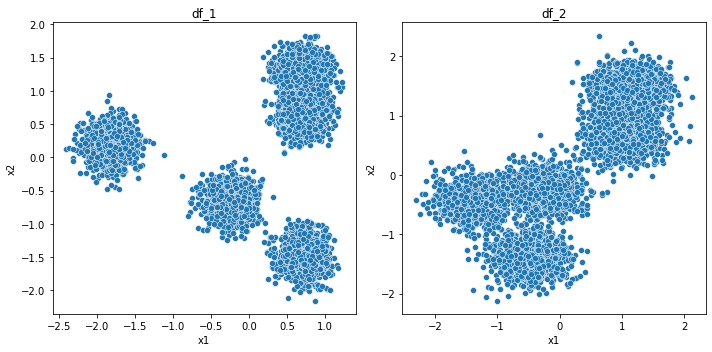

<IPython.core.display.Javascript object>

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x="x1", y="x2", data=df_1, ax=axes[0])
sns.scatterplot(x="x1", y="x2", data=df_2, ax=axes[1])
axes[0].set_title("df_1")
axes[1].set_title("df_2")
plt.tight_layout()
plt.show()

`df_3` is binary data representing True/False responses to a survey

In [11]:
# Co-occurance matrix

# Read as how many times the question in
# the column was True at the same time the
# row question was True

# The diagonal represents how many times the question
# was answered as True

# For example, we can see q4 was the question was
# likely answered as True

# For example, q2 and q4 were commonly answered as True together
# 2222 times (44% of responses) is the highest off-diagonal number

# For example, q1 and q5 were rarely answered as True together
# 246 times (5% of responses) is the lowest number

co_occur = df_3.T.dot(df_3)
co_occur_percent = co_occur / df_3.shape[0]

print("Co-occurances")
display(co_occur.style.background_gradient(axis=None))

print("Co-occurances as a percent of responses")
display(co_occur_percent.style.background_gradient(axis=None))

Co-occurances


,q1,q2,q3,q4,q5
q1,2496,1186,1245,1730,246
q2,1186,2491,1240,2222,781
q3,1245,1240,2492,1723,748
q4,1730,2222,1723,3493,1059
q5,246,781,748,1059,1516


Co-occurances as a percent of responses


,q1,q2,q3,q4,q5
q1,0.499200,0.237200,0.249000,0.346000,0.049200
q2,0.237200,0.498200,0.248000,0.444400,0.156200
q3,0.249000,0.248000,0.498400,0.344600,0.149600
q4,0.346000,0.444400,0.344600,0.698600,0.211800
q5,0.049200,0.156200,0.149600,0.211800,0.303200


<IPython.core.display.Javascript object>

`df_4` is categorical data

In [12]:
# Again, co-occurances

# We see Innovato seems to be more associated with Africa and Asia
# We see UpDog is associated with Europe and South America

crosstab = pd.crosstab([df_4["company"], df_4["continent"]], df_4["dept"])
crosstab.style.background_gradient(axis=None)

<IPython.core.display.Javascript object>

`df_5` is a combination of `df_1`, `df_3`, and `df_4`.

In [13]:
df_5.head()

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato
3,0.505617,1.020197,0,0,1,0,1,Europe,IT,Rop
4,0.234860,-1.424100,0,1,1,1,0,Europe,Marketing,Rop


<IPython.core.display.Javascript object>

## KMeans

[back to top](#Clustering-Algorithms)

In [14]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [15]:
df_1.head()

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344
3,0.505617,1.020197
4,0.234860,-1.424100


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_2`

In [16]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_3`

In [17]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_4`

In [18]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_5`

In [19]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

## kmedoids

[back to top](#Clustering-Algorithms)

In [20]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [21]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_2`

In [22]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_3`

In [23]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_4`

In [24]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_5`

In [25]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

## AgglomerativeClustering

[back to top](#Clustering-Algorithms)

In [26]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [27]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_2`

In [28]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_3`

In [29]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_4`

In [30]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_5`

In [31]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

## DBSCAN

[back to top](#Clustering-Algorithms)

In [32]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [33]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_2`

In [34]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_3`

In [35]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_4`

In [36]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_5`

In [37]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

## GaussianMixture

[back to top](#Clustering-Algorithms)

In [38]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [39]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_2`

In [40]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_3`

In [41]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_4`

In [42]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_5`

In [43]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

## MeanShift

[back to top](#Clustering-Algorithms)

In [44]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [45]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_2`

In [46]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_3`

In [47]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_4`

In [48]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_5`

In [49]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

## AffinityPropagation

[back to top](#Clustering-Algorithms)

In [50]:
# reset data for section
df_1, df_2 = make_df_1_2()
df_3 = make_df_3()
df_4 = make_df_4()
df_5 = make_df_5()

<IPython.core.display.Javascript object>

`df_1`

In [51]:
df_1.head(3)

,x1,x2
0,0.828952,-1.287727
1,-2.068668,-0.025076
2,-0.466015,-0.515344


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_2`

In [52]:
df_2.head(3)

,x1,x2
0,0.081766,-0.216337
1,1.368599,1.401082
2,1.612872,1.564719


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_3`

In [53]:
df_3.head(3)

,q1,q2,q3,q4,q5
0,0,0,0,1,0
1,1,0,1,1,0
2,0,0,0,1,1


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_4`

In [54]:
df_4.head(3)

,continent,dept,company
0,Europe,IT,UpDog
1,South America,IT,UpDog
2,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?

`df_5`

In [55]:
df_5.head(3)

,x1,x2,q1,q2,q3,q4,q5,continent,dept,company
0,0.828952,-1.287727,0,0,0,1,0,Europe,IT,UpDog
1,-2.068668,-0.025076,1,0,1,1,0,South America,IT,UpDog
2,-0.466015,-0.515344,0,0,0,1,1,Africa,IT,Innovato


<IPython.core.display.Javascript object>

Perform any additional EDA & preprocessing.

Fit model

Explore results visually and numerically.

Can the model be improved? What parameters does this algorithm give you the ability to adjust? How would adjusting that effect the output?